# Praca Domowa 7
Bartosz Siński

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
np.set_seed = 42

In [96]:
train = pd.read_csv("./src/wine_train.csv")
test = pd.read_csv("./src/wine_test.csv")
val = pd.read_csv("./src/wine_val.csv")

In [97]:
test.head(5)

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0,13.34,0.94,2.36,17.0,110,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750
1,0,12.00,0.92,2.00,19.0,86,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278
2,0,11.84,0.89,2.58,18.0,94,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520
3,0,12.47,1.52,2.20,19.0,162,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937
4,0,11.81,2.12,2.74,21.5,134,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625


In [84]:
#from sklearn.preprocessing import StandardScaler
#train = StandardScaler().fit_transform(train)
#val = StandardScaler().fit_transform(val)
#test1 = StandardScaler().fit_transform(test.drop('class',axis=1))
#test = pd.merge(pd.DataFrame(test1),test['class'],left_index=True, right_index=True)
# po standaryzacji danych nasz metoda radziła sobie gorzej i nie zauważała dobrze 
# outlierów więc nie będziemy jej stosować

### Znalezienie optymalnej liczby klastrów

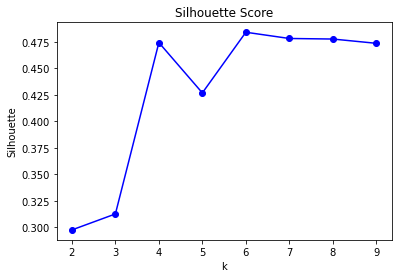

In [98]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
ss_scores = []
k = range(2,10)
for i in k:
    gm = GaussianMixture(n_components=i, random_state=0)
    gm.fit(train)
    labels = gm.predict(train)
    ss_scores.append(silhouette_score(train, labels, random_state = 42))
plt.plot(k,ss_scores,'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette Score')
plt.show()

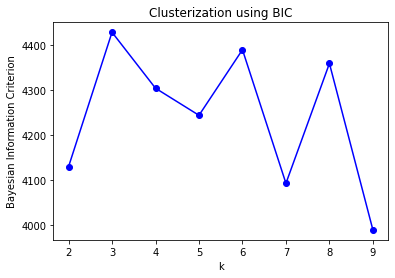

In [99]:
bic_scores = []
k = range(2,10)
for i in k:
    gm = GaussianMixture(n_components=i, random_state=0)
    gm.fit(train)
    bic_scores.append(gm.bic(train))
plt.plot(k,bic_scores,'bo-')
plt.xlabel('k')
plt.ylabel('Bayesian Information Criterion')
plt.title('Clusterization using BIC')
plt.show()

Obie przetestowane przez nas metody wykazują, że najbardziej optymalną liczbą klastrów dla GMM na naszych danych jest k=4.

### Znajdowanie wartości odstających
Do znajdowania wartości ostających posłużymy się wartościami *score_samples*, które są zwracane przez GMM dla każdej obserwacji. Oznaczają one ważony logarytm prawdopodobieństwa należenia tej obserwacji do wyznaczonych klastrów.

In [100]:
gm2 = GaussianMixture(n_components=4, random_state=42)
gm2.fit(train)

GaussianMixture(n_components=4, random_state=42)

Sprawdzimy czy dopasowany do zbioru treningowego GMM wykryje outliery na zbiorze walidacyjnym.

<AxesSubplot:ylabel='Count'>

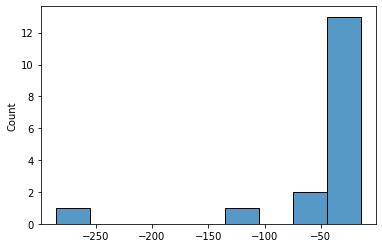

In [101]:
val_scores = gm2.score_samples(val)
sns.histplot(val_scores,bins=9)

Dwa widać dla obserwacji z wartościami *score_samples* < -100 . Taki też wyznaczymy próg uznawania obserwacji za odstające. Sprawdźmy na zbiorze testowym jak sprawdza się wybrany przez nas próg. 

In [102]:
test2 = test.drop('class',axis=1)

<AxesSubplot:ylabel='Count'>

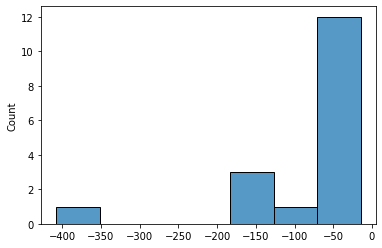

In [103]:
test_scores=gm2.score_samples(test2)
sns.histplot(test_scores)

In [104]:
results = np.where(gm2.score_samples(test2)<-100,1,0)
results

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

In [105]:
actual = test['class'].to_numpy()
actual

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [107]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("F1 score:" + str(f1_score(actual,results)))
print("Precision:" + str(precision_score(actual,results)))
print("Recall:" + str(recall_score(actual,results)))

F1 score:0.888888888888889
Precision:1.0
Recall:0.8


Nasza metoda dobrze poradziła sobie z wyrkywaniem outlierów przypisując myląc się jedynie przy jednej obserwacji, w przypadku której wartość odstającą uznała za normalną.